# Calibrate SwiGLU Pricer with `SciPy`

## 导入模型

In [1]:
import numpy as np
# import pandas as pd

import torch 

import sys
sys.path.append('../')
sys.path.append('../../')

# 导入模型
from Networks.nn import NN_pricing_SwiGLU
from Pricing.rBergomi.rBergomi_utils import *
from calibrate_utils import *

# 评估使用 cpu
device = torch.device('cpu')

# 设置参数为 4 个
hyperparams = { 
    'input_dim': 4, 
    'hidden_dim': 64, 
    'hidden_nums': 4,
    'output_dim': 88
}

model = NN_pricing_SwiGLU(hyperparams=hyperparams).to(device=device, dtype=torch.float64)


model_state = torch.load( 
    r'../../Results/models/SwiGLU_rBergomi_flat_forward_variance.pth'
)
model.load_state_dict(model_state)

# 设置为 eval mode
model.eval()
model.to(device=device, dtype=torch.float64)

NN_pricing_SwiGLU(
  (layer_lst): ModuleList(
    (0): SwiGLUBlock(
      (projection): Linear(in_features=4, out_features=64, bias=True)
      (gate): Linear(in_features=4, out_features=64, bias=True)
    )
    (1-3): 3 x SwiGLUBlock(
      (projection): Linear(in_features=64, out_features=64, bias=True)
      (gate): Linear(in_features=64, out_features=64, bias=True)
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (output_layer): Linear(in_features=64, out_features=88, bias=True)
)

## 数据

In [2]:
xx, yy, strikes, maturities = data_read(r"../../Data/rBergomiTrainSet.txt.gz")

# 训练集的 Upper and Lower Bounds
upper_bound = np.array([0.16,4,-0.1,0.5])
lower_bound = np.array([0.01,0.3,-0.95,0.025])

x_train_transform, y_train_transform, x_test_transform, y_test_transform = get_transform_train_test_data(xx, yy, upper_bound, lower_bound, 0.15)

网格数据形状：(40000, 92)
参数形状：(40000, 4)
隐含波动率曲面形状：(40000, 88)
参数上界: [ 0.16      4.       -0.100011  0.499998]
参数下界: [ 0.0100133  0.300028  -0.949934   0.0250066]


## `SciPy` 校准

### 优化

In [3]:
def CostFunc(x,sample_ind):
    return np.sum( 
        np.power((model(torch.from_numpy(x)).detach().numpy() - y_test_transform[sample_ind]),2)
    )

Approx_scipy, Timing_scipy = calibrate_with_scipy(CostFunc, x_test_transform[:1000], upper_bound, lower_bound)

SciPy 优化结果 (前 3 轮):
 [[[ 0.10458155  0.5708503  -0.749414    0.24719907]
  [ 0.10458156  0.57085155 -0.74941243  0.24719921]
  [ 0.10458155  0.57085026 -0.74941405  0.24719907]]

 [[ 0.15553969  3.37042701 -0.45475372  0.3005713 ]
  [ 0.15553969  3.37042712 -0.45475375  0.30057122]
  [ 0.15553968  3.37042695 -0.45475373  0.30057129]]

 [[ 0.09233448  1.98150107 -0.63591866  0.14011073]
  [ 0.09233448  1.98150106 -0.63591867  0.14011072]
  [ 0.09233448  1.98150105 -0.63591866  0.14011074]]]
SciPy 优化时间 (前 3 轮):
 [array([0.05533743, 0.04240012, 0.11287999]), array([0.03019333, 0.03262019, 0.09942722]), array([0.0305953 , 0.03157473, 0.07548523])]


In [ ]:
# methods=["L-BFGS-B ","SLSQP","BFGS"]

# for i in range(3):
#     Approx_scipy_lst=[Approx_scipy[j][i] for j in range(len(Approx_scipy))]
#     Timing_scipy_lst=[Timing_scipy[j][i] for j in range(len(Timing_scipy))]

#     np.savetxt(f"../../Results/Calibration/rBergomi_SwiGLU_calibrate_scipy_quasi_newton_{methods[i]}.txt", Approx_scipy_lst)
#     np.savetxt(f"../../Results/Calibration/rBergomi_SwiGLU_calibrate_scipy_quasi_newton_{methods[i]}_time.txt", Timing_scipy_lst)


### 可视化

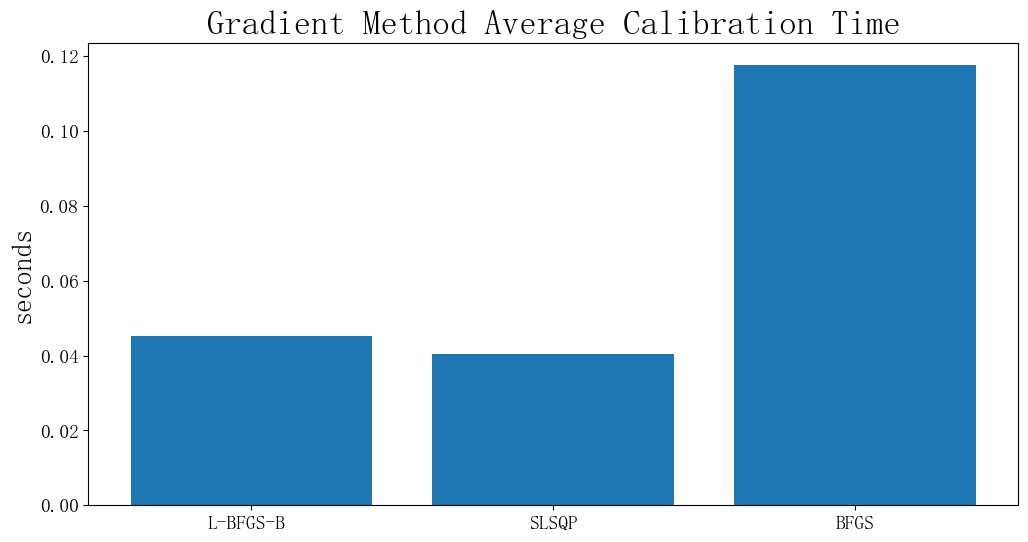

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

methods=["L-BFGS-B ","SLSQP","BFGS"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing_scipy,axis=0))
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("seconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

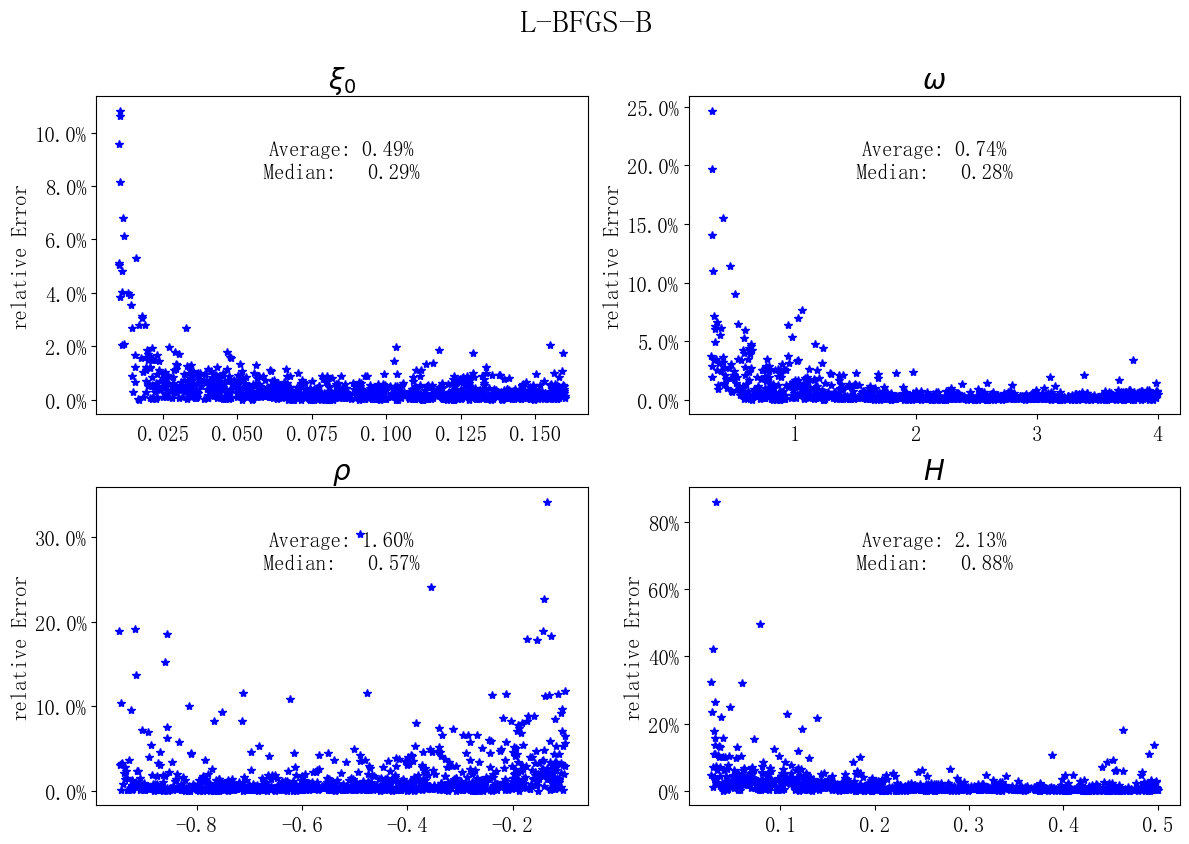

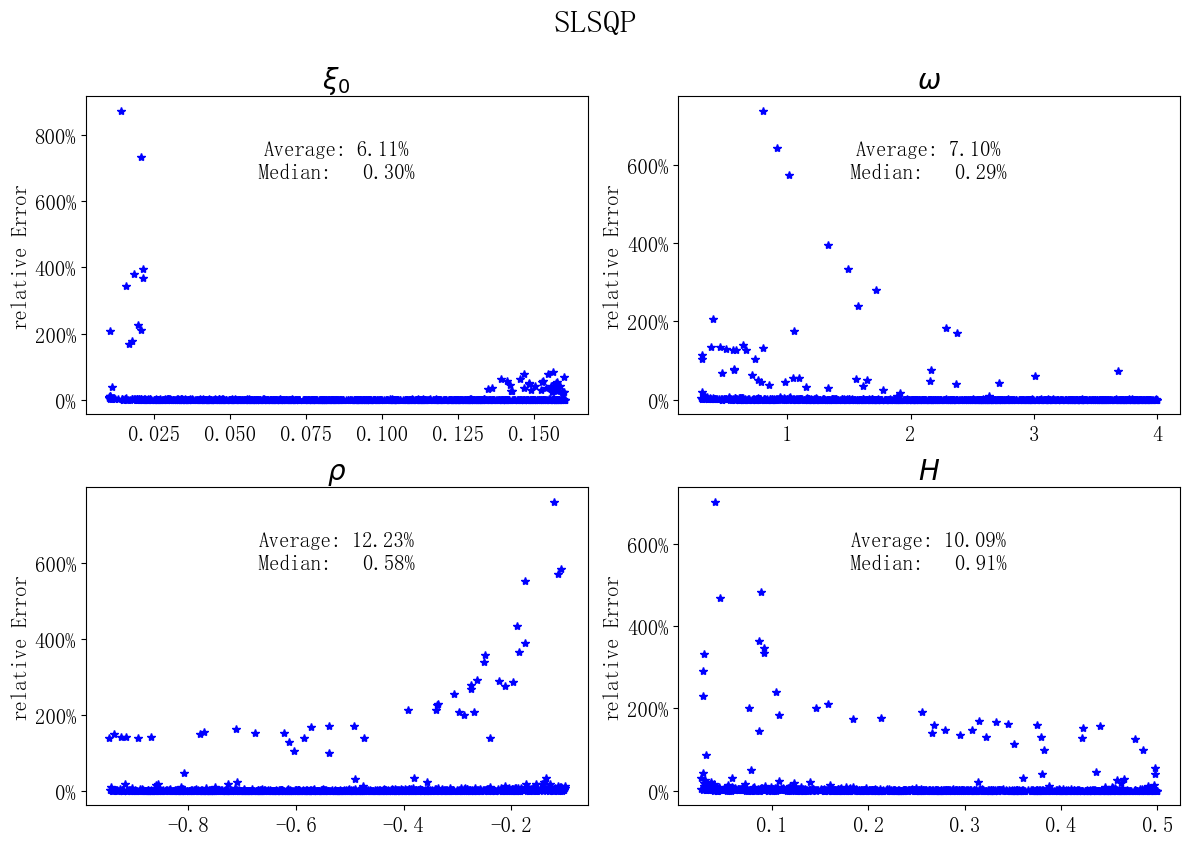

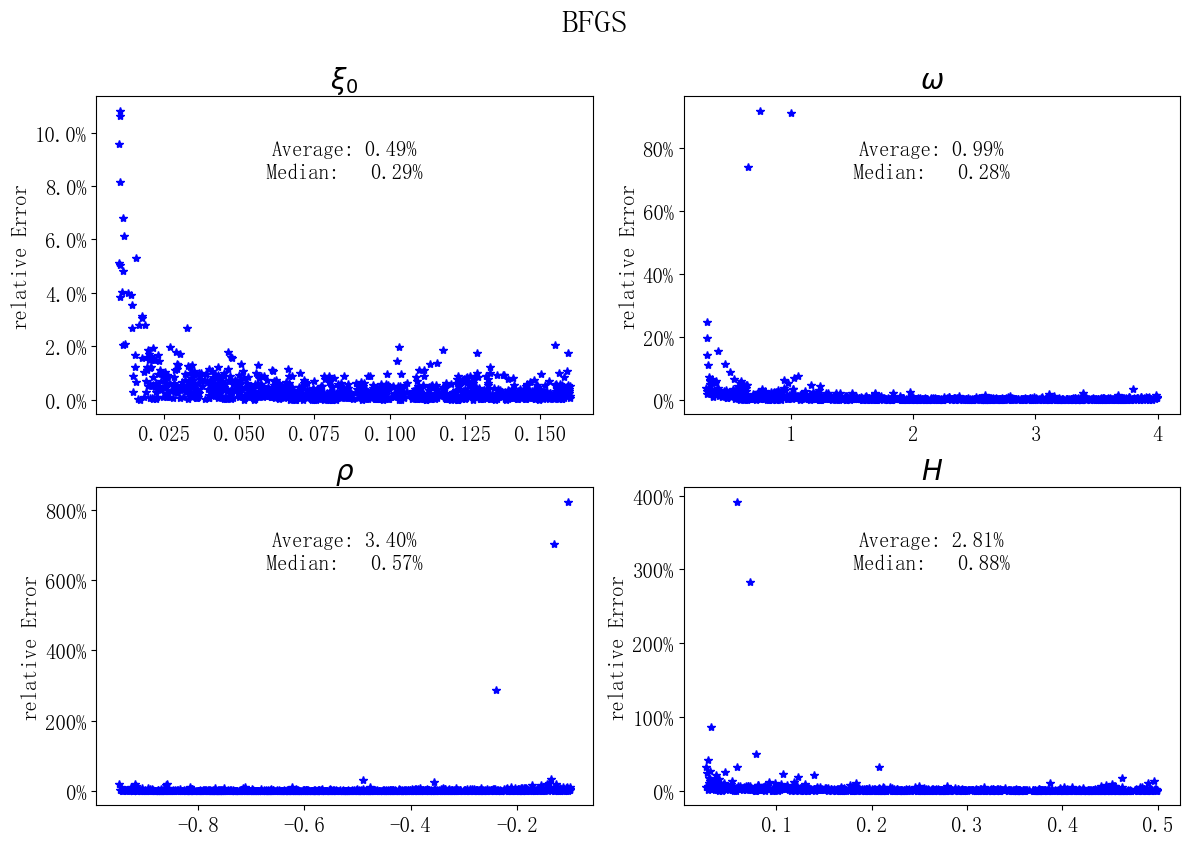

In [5]:
x_test = params_inv_scaler(x_test_transform, upper_bound, lower_bound)

for mtd in range(3):
    LMParameters = [Approx_scipy[i][mtd] for i in range(len(Approx_scipy))]
    LMParameters = np.array(LMParameters)

    titles=["$\\xi_0$","$\\omega$","$\\rho$","$H$"]
    average=np.zeros([4,1000])
    fig=plt.figure(figsize=(12,8))
    for u in range(4):
        ax=plt.subplot(2,2,u+1)
        x=x_test[:1000,u]
        plt.plot(x,100*np.abs(LMParameters[:1000,u]-x)/np.abs(x),'b*')
        average[u,:]=np.abs(LMParameters[:1000,u]-x)/np.abs(x)
        
        plt.title(titles[u],fontsize=20)
        plt.ylabel('relative Error',fontsize=15)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
        plt.tick_params(axis='both', which='major', labelsize=15)
        plt.tick_params(axis='both', which='minor', labelsize=15)
        plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
    plt.tight_layout()
    plt.suptitle(f"{methods[mtd]}", fontsize=24, y=1.05)
    plt.show()